In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [2]:
data = fetch_california_housing()

In [3]:
data.data[:1000,:]

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   4.7361    ,   22.        ,    6.08021978, ...,    2.71868132,
          37.7       , -121.8       ],
       [   5.4324    ,   17.        ,    5.97583082, ...,    3.35649547,
          37.69      , -121.8       ],
       [   4.9375    ,   12.        ,    5.97492163, ...,    2.51410658,
          37.69      , -121.82      ]], shape=(1000, 8))

In [4]:
len(np.random.permutation(range(1000)))

1000

In [5]:
np.random.seed(0)
data_points = np.random.permutation(range(len(data.data)))
X = data.data[data_points[:1000],:]
y = data.target[data_points[:1000]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 8), (200, 8), (800,), (200,))

## Fit a fully grown tree

In [8]:
rt = DecisionTreeRegressor(random_state=0)
rt.fit(X=X_train, y=y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [9]:
y_pred_train = rt.predict(X_train)
y_pred_test = rt.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Training MSE:', mse_train)
print('Test MSE:', mse_test)

Training MSE: 6.310887241768095e-32
Test MSE: 0.8103146711030002


In [10]:
print('Tree depth:', rt.tree_.max_depth)
print('Tree node count:', rt.tree_.node_count)

Tree depth: 21
Tree node count: 1543


In [11]:
# plt.figure(figsize=(15,15))
# print(plot_tree(rt, filled=True, fontsize=8))

## Cost complexity Prunning

In [12]:
path = rt.cost_complexity_pruning_path(X_train, y_train)

In [13]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [14]:
# ccp_alphas, impurities

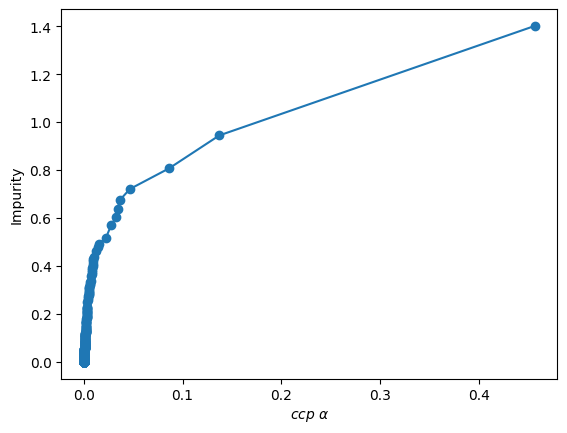

In [15]:
plt.plot(ccp_alphas, impurities, marker = 'o')
plt.xlabel(r'$ccp~\alpha$')
plt.ylabel('Impurity')
plt.show()

In [16]:
# Remove the last tree (only root), not useful for accuracy
ccp_alphas = np.unique(ccp_alphas)[:-1]
# ccp_alphas

In [17]:
cv_mse = []  # Store results

# Compute cross-validated avg MSE for each candidate ccp_alpha
for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    scores = cross_val_score(dt, X_train, y_train, cv=KFold(5, shuffle=True, random_state=0), 
                             scoring='neg_mean_squared_error', n_jobs=-1)
    cv_mse.append(np.mean(-scores))

In [18]:
# Choose best alpha
best_alpha = ccp_alphas[np.argmin(cv_mse)]
print("Best alpha:", best_alpha)
print("Minimum CV_MSE:", np.min(cv_mse))

Best alpha: 0.01278710155440857
Minimum CV_MSE: 0.6486230207979279


Text(0, 0.5, 'Avg CV MSE')

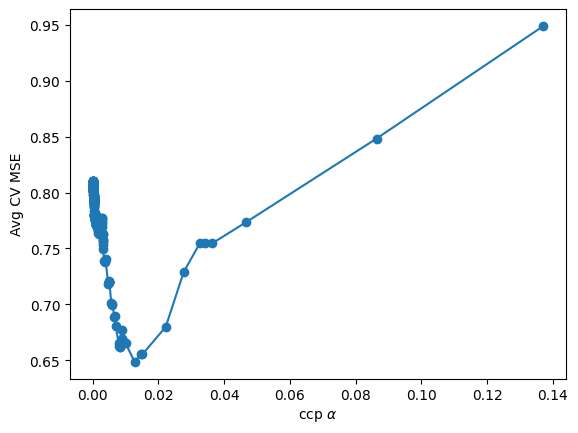

In [19]:
plt.plot(ccp_alphas, cv_mse, marker = 'o')
plt.xlabel(r'ccp $\alpha$')
plt.ylabel('Avg CV MSE')

## Final Tree

In [20]:
# Fit final model with best alpha
final_tree = DecisionTreeRegressor(random_state=0, ccp_alpha=0.01279)
final_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.002023


In [21]:
y_pred_train = final_tree.predict(X_train)
y_pred_test = final_tree.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print('Training MSE:', mse_train)
print('Test MSE:', mse_test)

Training MSE: 0.13661371647446455
Test MSE: 0.6576990232241261


In [22]:
print('Tree depth:', final_tree.tree_.max_depth)
print('Tree node count:', final_tree.tree_.node_count)

Tree depth: 15
Tree node count: 169


## Some diagrams

In [23]:
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=alpha, random_state=0)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [24]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

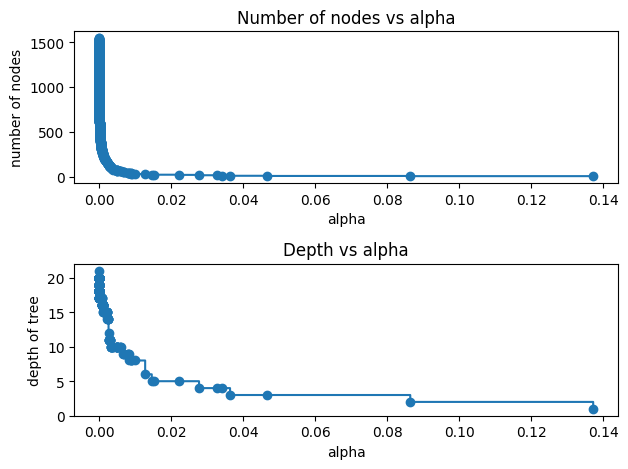

In [25]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Plotting train and test MSE for various prunned subtrees

In [26]:
train_scores = [mean_squared_error(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [mean_squared_error(y_test, clf.predict(X_test)) for clf in clfs]

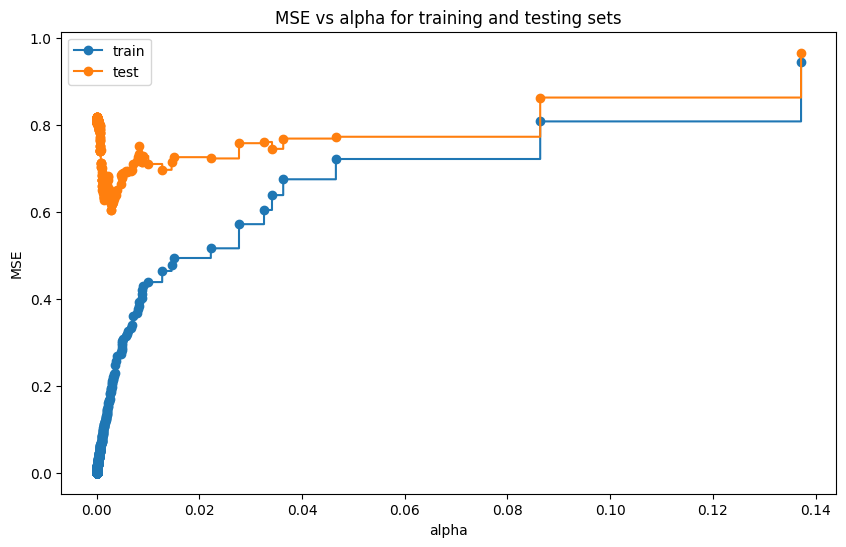

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [28]:
AA = pd.DataFrame({'node_counts':node_counts, 
                   'depth': depth, 
                   'train_mses': train_scores, 
                   'test_mses': test_scores, 
                   'ccp_alphas': ccp_alphas,
                   'cv':cv_mse})
AA.iloc[np.append(0,np.arange(325,335)), :]

,node_counts,depth,train_mses,test_mses,ccp_alphas,cv
0,1543,21,6.310887e-32,0.810315,0.000000,0.803965
325,871,18,1.535814e-03,0.807126,0.000022,0.805523
326,869,18,1.557670e-03,0.807126,0.000022,0.805523
327,867,18,1.579540e-03,0.806118,0.000022,0.805697
328,863,18,1.623924e-03,0.806441,0.000022,0.805686
329,861,18,1.646611e-03,0.804362,0.000023,0.805617
330,859,18,1.670049e-03,0.805366,0.000023,0.805252
331,857,18,1.693569e-03,0.804665,0.000024,0.805252
332,855,18,1.717091e-03,0.804665,0.000024,0.805252
333,853,18,1.740614e-03,0.805471,0.000024,0.805252


## Linear regression

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression()
model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [31]:
print('*********Linear regression scores*********')
print('Train MSE: ', mean_squared_error(y_train, model.predict(X_train)))
print('Test MSE: ', mean_squared_error(y_test, model.predict(X_test)))

*********Linear regression scores*********
Train MSE:  0.5043708098118871
Test MSE:  0.5657403380005105
